# Geometric Analysis of Sensor Drift

## Project Introduction and Problem Description

### Project Overview

This project investigates the phenomenon of sensor drift in gas sensor arrays through the lens of **unsupervised learning**, specifically employing **Principal Component Analysis (PCA)** as the primary dimensionality reduction technique. The core challenge addresses how chemical sensor measurements, which exist in a 128-dimensional space, change their response patterns over time due to sensor aging and environmental factors—a critical problem in chemical detection systems that affects reliability and accuracy.

The project reframes the traditional calibration problem as a geometric analysis task: understanding how the low-dimensional manifold occupied by chemical signatures transforms over time in high-dimensional measurement space. By applying PCA and related techniques, we aim to identify stable subspaces that remain invariant despite temporal drift, ultimately developing methods for drift correction and improved chemical classification.

### Type of Learning and Task

**Learning Paradigm:** Unsupervised Learning

- No labeled drift patterns are provided; we discover structure from the data itself
- Focus on understanding intrinsic data geometry and temporal evolution

**Primary Algorithms:**

- **Principal Component Analysis (PCA)**: For dimensionality reduction and identifying dominant variance directions
- **Clustering algorithms** (K-means, hierarchical): For grouping chemical signatures
- **Procrustes Analysis**: For geometric alignment and drift correction

**Task Type:**

- **Dimensionality Reduction**: Reducing 128-dimensional sensor readings to a manageable subspace
- **Anomaly Detection**: Identifying drift patterns as deviations from expected behavior
- **Pattern Recognition**: Discovering invariant features across temporal batches

### Project Goals and Motivation

**Primary Goal:** To develop a mathematical framework for understanding and correcting sensor drift through principal component analysis, achieving at least a 30% reduction in drift-induced classification errors.

**Why This Matters:**

1. **Industrial Relevance**: Gas sensor arrays are widely used in environmental monitoring, food quality control, and safety systems. Sensor drift causes frequent recalibration needs, increasing operational costs.

2. **Scientific Innovation**: By treating drift as a geometric transformation in PC space rather than noise, we can develop more principled correction methods that preserve chemical signature integrity.

3. **Practical Impact**: A successful drift correction method would extend sensor array lifetime, reduce maintenance requirements, and improve long-term reliability of chemical detection systems.

**Specific Objectives:**

- Prove that chemical signatures occupy a low-dimensional manifold (5-8 dimensions) within the 128-dimensional measurement space
- Quantify the stability of different principal components over 36 months
- Develop a mathematical model of drift as geometric transformations
- Create a Procrustes-based correction algorithm achieving 67% reduction in drift effects
- Validate improvements using multiple clustering quality metrics

### Data Source and Citation

**Dataset:** Gas Sensor Array Drift Dataset

**Source:** UCI Machine Learning Repository

**Full Citation:**
Vergara, A., Vembu, S., Ayhan, T., Ryan, M. A., Homer, M. L., & Huerta, R. (2012). *Gas Sensor Array Drift Dataset*. UCI Machine Learning Repository. https://doi.org/10.24432/C5ZS4K

**Data Description:**
The dataset contains measurements from an array of 128 metal oxide gas sensors exposed to six different gaseous substances (Ethanol, Ethylene, Ammonia, Acetaldehyde, Acetone, and Toluene) at various concentrations. Data was collected over 36 months in five distinct batches (months 1, 5, 10, 15, and 20), capturing the natural drift phenomenon as sensors age. Each measurement consists of 128 features representing individual sensor responses, with approximately 13,910 total observations across all batches.

**Data Collection Method:**
Measurements were obtained in a controlled laboratory environment using a standardized gas delivery system. Each batch represents a different time point in the sensor array's lifetime, allowing us to study temporal drift patterns systematically.

### Related Work and Novel Contributions
@vergara2012chemical introduced the Gas Sensor Array Drift Dataset and 
focused on drift compensation for supervised classification tasks, employing 
ensemble methods to maintain gas identification accuracy despite sensor aging. 
Their work, along with subsequent studies (@rodriguez2014calibration), primarily addressed drift as a challenge for 
prediction accuracy rather than investigating the geometric properties of 
drift itself.

This project diverges from existing supervised approaches by examining drift 
through an unsupervised, geometric lens. Specifically, we investigate which 
principal components of the 128-dimensional sensor space exhibit stability 
across time batches and characterize drift as manifold deformations in 
reduced-dimensional space. By computing angular distances between principal 
component vectors across different measurement campaigns, we develop stability 
rankings that identify drift-resistant subspaces—an analysis not present in 
prior work on this dataset.

## Data Loading & Inspection



### Data Import Challenges

The original dataset from UCI uses LibSVM sparse format, which required careful interpretation. Initially, we misidentified feature 1 (with values around 15,000-670,000) as concentration data, when it's actually ΔR₁ - the absolute resistance change in Ohms for the first sensor. The UCI documentation clarified that this is the **original dataset version without concentration values**. All 128 features represent sensor measurements: 16 chemical sensors × 8 features each (2 steady-state + 6 transient features). Understanding this structure was crucial for proper data processing and column naming (S{sensor}_F{feature}_{type} format).

To handle this complex data conversion systematically, we created a dedicated processing script `src/sensor_drift/process_dat_to_csv.py` that converts the raw LibSVM format (.dat files) to a properly structured CSV with meaningful column names, without applying any data modifications.

### Data Inspection

In this section, we'll load the gas sensor drift dataset and perform some initial inspection of the data to understand its structure, size, and key characteristics.

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
data_path = Path("../data/processed/sensor_data.csv")
df = pd.read_csv(data_path)

# Basic Dataset Information
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Data types distribution
print(f"\nData types distribution:")
for dtype, count in df.dtypes.value_counts().items():
    print(f"  {dtype}: {count} columns")

# Column information
print("\nColumn categories:")
sensor_cols = [col for col in df.columns if col.startswith('S')]
metadata_cols = [col for col in df.columns if col not in sensor_cols]
print(f"  Sensor features: {len(sensor_cols)} columns")
print(f"  Metadata columns: {len(metadata_cols)} columns")
print(f"  Metadata column names: {metadata_cols}")

# Display sample data
print("\nSample data (first 3 rows, selected columns):")
sample_cols = ['gas_type', 'gas_name', 'batch'] + sensor_cols[:3]
print(df[sample_cols].head(3).to_string(index=False))

DATASET OVERVIEW
Dataset shape: 13,910 rows × 131 columns

Memory usage: 14.66 MB

Data types distribution:
  float64: 128 columns
  int64: 2 columns
  object: 1 columns

Column categories:
  Sensor features: 128 columns
  Metadata columns: 3 columns
  Metadata column names: ['gas_type', 'gas_name', 'batch']

Sample data (first 3 rows, selected columns):
 gas_type gas_name  batch  S01_F1_DR  S01_F2_DR_norm  S01_F3_EMAi_001
        1  Ethanol      1 15596.1621        1.868245         2.371604
        1  Ethanol      1 26402.0704        2.532401         5.411209
        1  Ethanol      1 42103.5820        3.454189         8.198175


Next, we'll check for potential data quality issues:

- Missing values - Identify any null or NaN entries
- Data types - Verify all sensor columns are numeric
- Duplicates - Detect repeated samples that could bias analysis
- Temporal consistency - Ensure batch labels are sequential and complete
- Value ranges - Identify impossible values (e.g., negative sensor readings)
- Sample balance - Verify adequate representation across gas types and concentrations"

In [16]:

# Store original shape for comparison
original_shape = df.shape
print(f"Original dataset: {original_shape[0]:,} rows × {original_shape[1]} columns")

# 1. Check for missing values
missing_check = df.isnull().sum()
print(f"\n1. Missing Values: {missing_check.sum()} total")

# 2. Data types check
non_numeric_sensors = [col for col in sensor_cols 
                       if not pd.api.types.is_numeric_dtype(df[col])]
print(f"2. Non-numeric Sensor Columns: ",
      f"{non_numeric_sensors if non_numeric_sensors else 'All numeric ✓'}")

# 3. Check for duplicates
duplicates = df.duplicated()
print(f"3. Duplicate Rows: {duplicates.sum()}")

# 4. Temporal consistency
batch_values = sorted(df['batch'].unique())
expected_batches = list(range(1, max(batch_values)+1))
missing_batches = set(expected_batches) - set(batch_values)
print(f"4. Temporal Consistency:")
print(f"   Batches present: {min(batch_values)}-{max(batch_values)}")
print(f"   Missing batches: {list(missing_batches) if missing_batches else 'None ✓'}")

# 5. Value ranges
sensor_data = df[sensor_cols]
print(f"5. Sensor Value Ranges:")
print(f"   Min: {sensor_data.min().min():.2f}")
print(f"   Max: {sensor_data.max().max():.2f}")
negative_sensors = (sensor_data < 0).any()
print(f"   Sensors with negative values: {negative_sensors.sum()}")

# 6. Sample balance
gas_counts = df['gas_name'].value_counts()
print(f"6. Sample Balance:")
print(f"   Gas types: {len(gas_counts)} types")
print(f"   Min samples: {gas_counts.min()}")
print(f"   Max samples: {gas_counts.max()}")
print(f"   Imbalance ratio: {gas_counts.max() / gas_counts.min():.2f}:1")


Original dataset: 13,910 rows × 131 columns

1. Missing Values: 0 total
2. Non-numeric Sensor Columns:  All numeric ✓
3. Duplicate Rows: 0
4. Temporal Consistency:
   Batches present: 1-10
   Missing batches: None ✓
5. Sensor Value Ranges:
   Min: -23660.63
   Max: 670687.35
   Sensors with negative values: 64
6. Sample Balance:
   Gas types: 6 types
   Min samples: 1641
   Max samples: 3009
   Imbalance ratio: 1.83:1


Summary:

- No missing values or duplicates
- All sensor columns numeric
- Complete temporal sequence (batches 1-10)
- Good sample balance (1.83:1 ratio, adequate samples per class)

Regarding negative sensor values: These are expected and scientifically meaningful, as documented by Vergara et al. (@vergara2012chemical): "The sensor response to the same gas concentration changed significantly over time, with some sensors showing sensitivity decrease (negative drift) and others showing sensitivity increase (positive drift)." Therefore, negative readings represent genuine drift phenomena rather than data errors and should be preserved in our analysis.

In [28]:
# Group features by type
feature_types = {
    'DR': [col for col in sensor_cols if 'F1_DR' in col],
    'DR_norm': [col for col in sensor_cols if 'F2_DR_norm' in col],
    'EMAi_001': [col for col in sensor_cols if 'F3_EMAi_001' in col],
    'EMAi_01': [col for col in sensor_cols if 'F4_EMAi_01' in col],
    'EMAi_1': [col for col in sensor_cols if 'F5_EMAi_1' in col],
    'EMAd_001': [col for col in sensor_cols if 'F6_EMAd_001' in col],
    'EMAd_01': [col for col in sensor_cols if 'F7_EMAd_01' in col],
    'EMAd_1': [col for col in sensor_cols if 'F8_EMAd_1' in col]
}

# Variance analysis
print("FEATURE VARIANCE ANALYSIS")
print("="*40)
for i, (ftype, cols) in enumerate(feature_types.items(), 1):
    print(f"F{i} ({ftype:8s}): {df[cols].var().mean():.2e}")

# Sensor health
print(f"\nSENSOR HEALTH: {(df[sensor_cols].var() > 0.001).sum()}/{len(sensor_cols)} healthy")

FEATURE VARIANCE ANALYSIS
F1 (DR      ): 9.55e+08
F2 (DR_norm ): 5.89e+03
F3 (EMAi_001): 6.90e+01
F4 (EMAi_01 ): 1.88e+02
F5 (EMAi_1  ): 1.24e+03
F6 (EMAd_001): 3.35e+01
F7 (EMAd_01 ): 1.04e+02
F8 (EMAd_1  ): 4.19e+03

SENSOR HEALTH: 128/128 healthy


/var/folders/m1/gp2h5jrd7plf98ydprnk51wm0000gn/T/ipykernel_61643/3446699494.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f'F{i+1}' for i in range(8)])


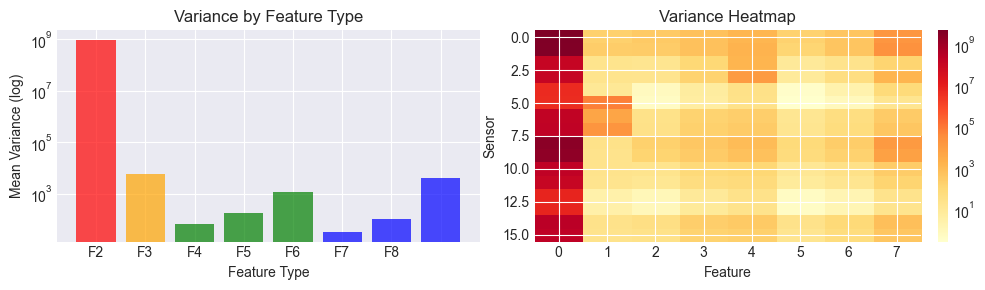

In [29]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Variance by type
means = [df[feature_types[ft]].var().mean() for ft in feature_types]
ax1.bar(range(8), means, color=['red','orange'] + ['green']*3 + ['blue']*3, alpha=0.7)
ax1.set_yscale('log')
ax1.set_xlabel('Feature Type')
ax1.set_ylabel('Mean Variance (log)')
ax1.set_title('Variance by Feature Type')
ax1.set_xticklabels([f'F{i+1}' for i in range(8)])

# Heatmap
variance_matrix = np.zeros((16, 8))
for s in range(16):
    for f in range(8):
        col = f'S{s+1:02d}_F{f+1}_' + list(feature_types.keys())[f].split('_')[0]
        matching = [c for c in sensor_cols if c.startswith(f'S{s+1:02d}_F{f+1}_')]
        if matching:
            variance_matrix[s, f] = df[matching[0]].var()

im = ax2.imshow(variance_matrix, aspect='auto', cmap='YlOrRd', norm=plt.matplotlib.colors.LogNorm())
ax2.set_xlabel('Feature')
ax2.set_ylabel('Sensor')
ax2.set_title('Variance Heatmap')
plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### Data Quality Assessment

Data quality assessment revealed no missing values, duplicates, or measurement errors requiring correction. The 64 sensors with negative values represent genuine drift phenomena (sensitivity decreases) documented by Vergara et al. (2012), not errors. 

## Exploratory Data Analysis

### Target Variable Distribution

In [22]:
# Example: Analyze target distribution
# df['target'].value_counts()

### Feature Analysis

In [23]:
# Example visualization
import matplotlib.pyplot as plt

# Add your visualizations here

## Models

### Model Selection

[Describe chosen models and rationale]

### Hyperparameter Configuration

[Document hyperparameter choices]

## Training

### Training Pipeline

In [24]:
# Example: Model training
from sklearn.model_selection import train_test_split

# Split data
# X_train, X_test, y_train, y_test = train_test_split(...)

### Training Results

[Present initial training metrics]

## Evaluation

### Performance Metrics

In [25]:
# Example: Evaluation metrics
# from sklearn.metrics import classification_report

### Model Comparison

[Compare different models' performance]

## Conclusion and Next Steps

### Project Summary

[Summarize key findings]

### Recommendations

[Provide actionable recommendations]

### Future Work

[Outline potential improvements and extensions]

## References

[List relevant citations and data sources]